In [211]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.model_selection import GridSearchCV

In [153]:
df = pd.read_csv('energy_dataset.csv')

In [154]:
# Convert datetime to int
df['time'] = pd.to_datetime(df['time'], utc=True).astype(int) / 10**9

In [155]:
# Missing values
 
# Replace missing values using linear interpolation
df = df.interpolate(method='linear', axis=0).ffill().bfill()

In [156]:
# Drop irrevelent columns

# Drop columns with only zeros
df = df.loc[:, (df != 0).any(axis=0)]

# Drop empty columns
df = df.dropna(how='all', axis=1)

df2 = df

# Drop forecast columns
df = df.drop(columns=['forecast solar day ahead', 'forecast wind onshore day ahead', 'total load forecast', 'price day ahead'])

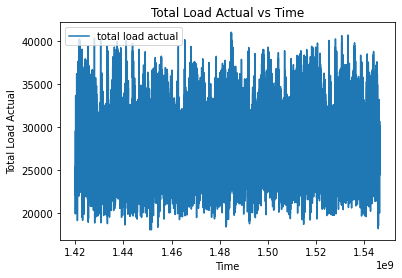

In [157]:
# Plot total load actual 
t = df['time']
load = df['total load actual']

plt.plot(t, load, label = "total load actual")

plt.xlabel('Time')
plt.ylabel('Total Load Actual')
plt.title('Total Load Actual vs Time')
plt.legend()
plt.show()

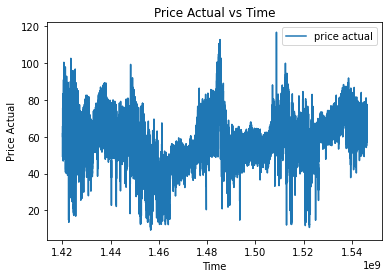

In [158]:
# Plot price actual
t = df['time']
price = df['price actual']

plt.plot(t, price, label = "price actual")

plt.xlabel('Time')
plt.ylabel('Price Actual')
plt.title('Price Actual vs Time')
plt.legend()
plt.show()

In [159]:
# Outlier Detection

# Detection using interquartile range
def iqr (s, k=1.5, thresholds=False):
    # calculate interquartile range
    q25, q75 = np.percentile(s, 25), np.percentile(s, 75)
    iqr = q75 - q25
    
    # calculate the outlier cutoff
    cut_off = iqr * k
    lower, upper = q25 - cut_off, q75 + cut_off
    
    if thresholds:
        return lower, upper
    else:
        # Identify outliers
        return [True if x < lower or x > upper else False for x in s]

# Create df showing outliers
ds = df.drop(columns=['time'], axis=1)
iqr_df = ds.apply(iqr, k=1.5) 

In [160]:
# Replace with nulls
for column in ds:
    ds[column] = np.where(iqr_df[column] == True, 'NaN', ds[column])
    
cols = ds.columns
ds[cols] = ds[cols].apply(pd.to_numeric, errors='coerce') 

In [161]:
# Fill the nulls
ds = ds.interpolate(method='linear', axis=0).ffill().bfill()
df = pd.concat([df['time'], ds], axis=1)

In [162]:
# Drop columns with only zeros
df = df.loc[:, (df != 0).any(axis=0)]

# Drop colunms with the same values
df = df.drop(df.std()[(df.std() == 0)].index, axis=1)

In [163]:
# We will create two models

# 1. Predict 'total load actual'
# 2. Predict 'price actual'

df_load = df.drop(columns=['price actual'])
df_price = df.drop(columns=['total load actual'])

In [203]:
# Split the data

# 70-30 split-----------------------------------

# Number of rows
num_row_l = len(df_load.index)
num_row_p = len(df_price.index)

# total actual load
train_l = df_load.iloc[0:int(num_row_l*0.7)]
test_l = df_load.iloc[int(num_row_l*0.7):]

# price actual
train_p = df_price.iloc[0:int(num_row_p*0.7)]
test_p = df_price.iloc[int(num_row_p*0.7):]

In [ ]:
# Y (Actual Price / Load) vs X ------------------------------------------

# total actual load
X_train_l = train_l.iloc[:,0:len(df_load.columns)-1].values
Y_train_l = train_l.iloc[:, len(df_load.columns)-1:].values

X_test_l = test_l.iloc[:,0:len(df_load.columns)-1].values
Y_test_l = test_l.iloc[:, len(df_load.columns)-1:].values

# price actual
X_train_p = train_p.iloc[:,0:len(df_price.columns)-1].values
Y_train_p = train_p.iloc[:, len(df_price.columns)-1:].values

X_test_p = test_p.iloc[:,0:len(df_price.columns)-1].values
Y_test_p = test_p.iloc[:, len(df_price.columns)-1:].values

In [212]:
# Feature Scaling
scaler = StandardScaler()

# total actual load
X_train_l = scaler.fit_transform(X_train_l)
Y_train_l = scaler.fit_transform(Y_train_l)

X_test_l = scaler.fit_transform(X_test_l)
Y_test_l = scaler.fit_transform(Y_test_l)

# price actual
X_train_p = scaler.fit_transform(X_train_p)
Y_train_p = scaler.fit_transform(Y_train_p)

X_test_p = scaler.fit_transform(X_test_p)
Y_test_p = scaler.fit_transform(Y_test_p)

In [166]:
# total actual load
svclassifier_l = SVR(kernel='rbf')
svclassifier_l.fit(X_train_l, Y_train_l.ravel())

y_pred_l = svclassifier_l.predict(X_test_l)

# price actual
svclassifier_p = SVR(kernel='rbf')
svclassifier_p.fit(X_train_p, Y_train_p.ravel())

y_pred_p = svclassifier_p.predict(X_test_p)

In [167]:
# Model Evaluation

# total actual load
r_squared_l = r2_score(Y_test_l, y_pred_l)
mae_l = mean_absolute_error(Y_test_l, y_pred_l)
mse_l = mean_squared_error(Y_test_l, y_pred_l)
rmse_l = np.sqrt(mse_l)
print('Total Actual Load')
print('R-Squared: ',r_squared_l)
print('Mean Absolute Error: ',mae_l)
print('Mean Squared Error: ',mse_l)
print('Root Mean Squared Error: ',rmse_l)

print('\n')

# price actual
r_squared_p = r2_score(Y_test_p, y_pred_p)
mae_p = mean_absolute_error(Y_test_p, y_pred_p)
mse_p = mean_squared_error(Y_test_p, y_pred_p)
rmse_p = np.sqrt(mse_p)
print('Price Actual')
print('R-Squared: ',r_squared_p)
print('Mean Absolute Error: ',mae_p)
print('Mean Squared Error: ',mse_p)
print('Root Mean Squared Error: ',rmse_p)

Total Actual Load
R-Squared:  0.8278689292201755
Mean Absolute Error:  0.3265325496821893
Mean Squared Error:  0.1721310707798245
Root Mean Squared Error:  0.414886816830596


Price Actual
R-Squared:  0.24875648141214224
Mean Absolute Error:  0.6577294090088371
Mean Squared Error:  0.7512435185878578
Root Mean Squared Error:  0.8667430522293547


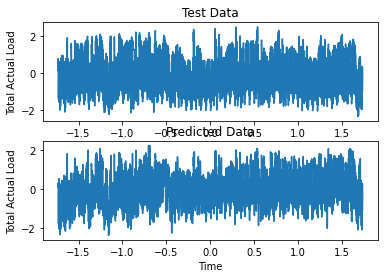

<Figure size 30000x2000 with 0 Axes>

In [187]:
# Comparison of Predicted Model to Actual: Load

fig, axis = plt.subplots(2)

# time
x_train_l = X_test_l[:,0:1]
# total actual load (test)
y_train_l = Y_test_l

# Test Data Plot
axis[0].plot(x_train_l, y_train_l)

# Prediction Data Plot
axis[1].plot(x_train_l, y_pred_l)

axis[0].set_title('Test Data')
axis[1].set_title('Predicted Data')

axis[0].set(xlabel='Time', ylabel='Total Actual Load')
axis[1].set(xlabel='Time', ylabel='Total Actual Load')

plt.figure(figsize=(20, 10), dpi= 100)
plt.show()

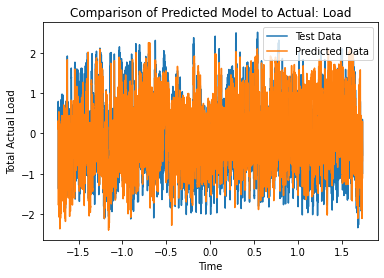

<Figure size 1440x720 with 0 Axes>

In [184]:
# Comparison of Predicted Model to Actual: Load

# time
x_train_l = X_test_l[:,0:1]
# total actual load (test)
y_train_l = Y_test_l

# Test Data Plot
plt.plot(x_train_l, y_train_l, label='Test Data')

# Prediction Data Plot
plt.plot(x_train_l, y_pred_l, label='Predicted Data')


plt.xlabel('Time')
plt.ylabel('Total Actual Load')
plt.title('Comparison of Predicted Model to Actual: Load')
plt.legend()
plt.figure(figsize=(20, 10))
plt.show()

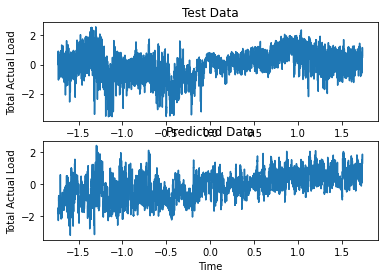

<Figure size 1440x720 with 0 Axes>

In [185]:
# Comparison of Predicted Model to Actual: Price

fig, axis = plt.subplots(2)

# time
x_train_p = X_test_p[:,0:1]
# total actual load (test)
y_train_ = Y_test_p

# Test Data Plot
axis[0].plot(x_train_p, y_train_p)

# Prediction Data Plot
axis[1].plot(x_train_p, y_pred_p)

axis[0].set_title('Test Data')
axis[1].set_title('Predicted Data')

axis[0].set(xlabel='Time', ylabel='Total Actual Load')
axis[1].set(xlabel='Time', ylabel='Total Actual Load')

plt.figure(figsize=(20, 10))
plt.show()

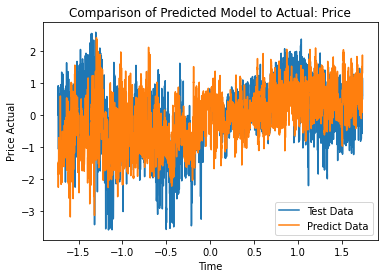

<Figure size 216x216 with 0 Axes>

In [170]:
# Comparison of Predicted Model to Actual: Price

# time
x_train_p = X_test_p[:,0:1]
# price actual (test)
y_train_p = Y_test_p

# Test Data Plot
plt.plot(x_train_p, y_train_p, label='Test Data')

# Prediction Data Plot
plt.plot(x_train_p, y_pred_p, label='Predict Data')


plt.xlabel('Time')
plt.ylabel('Price Actual')
plt.title('Comparison of Predicted Model to Actual: Price')
plt.legend()
plt.figure(figsize=(3, 3))
plt.show()

In [ ]:
# Hyperparameter Tuning

# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  

grid = GridSearchCV(SVR(), param_grid, refit = True, verbose = 3) 

# fitting the model for grid search 
grid.fit(X_train_l, Y_train_l.ravel()) 

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.153, total=  11.5s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.4s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.259, total=  11.7s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   23.1s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.269, total=  11.9s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.303, total=  11.7s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.146, total=  11.5s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.893, total=   9.2s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.932, total=   9.4s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.898, total=   9.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.887, total=   8.9s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.889, total=  14.8s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.937, total=  15.2s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.899, total=  15.0s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.892, total=  15.2s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.873, total=  15.1s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.938, total=  10.6s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.930, total=  10.9s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .

In [ ]:
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 